In [1]:
%%capture
!pip install xlrd
!pip install --upgrade xlrd
!pip install teemi

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns

# 06_1_TEST_LibraryCharacterisation

<a target="_blank" href="https://colab.research.google.com/github/hiyama341/teemi/blob/main/colab_notebooks/06_1_TEST_LibraryCharacterisation.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

We can import the datarepository like this:

In [3]:
!git clone https://github.com/hiyama341/G8H_CPR_library.git

fatal: destination path 'G8H_CPR_library' already exists and is not an empty directory.


# 0. Intro

In this notebook we continue the workflow by analyzing the first combinatorial library. To do so, we use determine strictosidine levels through massspectrometry of the generated strains from the previously generated library [05_1_BUILD_CombinatorialLibrary_AllStrain](../colab_notebooks/05_1_BUILD_CombinatorialLibrary_AllStrains.ipynb) and genotype the strains by sanger sequencing to determine promoter:gene combinations. 

## Project overview - Phenotyping:Genotyping the combinatorial library. 

**Hypothesis**
1. Specific combinations of CPR / G8H homologs and corresponding expression levels can remove the G8H bottleneck in the Strictosidine pathway

Aim: To test the hypothesis

Tasks
1. dgRNA
2. Base strain
3. Library
**4. Phenotyping/Genotyping**
   - Phenotyping : Data wrangling of LC-MS data
   - Genotyping : Sanger sequencing
   - Plotting the results
5. Machine Learning


# 1. DATA wrangling

In this section the objective is to: 
    
    1. Import data from LC-MS analysis
    2. Merge that data with information on the plate setup and enzyme homologs (i.e. what each well has produced)
    3. Import sequencing data - filter it
    4. Genotype the different wells to determine promoters to each strain
    5. Merge all the data so we end up with the following for each well analysed: 
        - Normalized production of strictosidine
        - Homolog combination 
        - Promoter combination 

With this information we can go to the next step which is the ML step. 

## 1.1 Merge Plate design yp49-52 metadata into single csv file


In [4]:
path = 'G8H_CPR_library/data/07-lcms/raw/plate_design/'

df1 = pd.read_excel(path + 'lc0001.xlsx').reset_index(drop=True)
df1["plate"] = 'yp49' 

df2 = pd.read_excel(path + 'lc0002.xlsx').reset_index(drop=True)
df2["plate"] = 'yp50' 

df3 = pd.read_excel(path + 'lc0003.xlsx').reset_index(drop=True)
df3["plate"] = 'yp51' 

df4 = pd.read_excel(path + 'lc0003.xlsx').reset_index(drop=True) # plate 52 has a few replicates that failed first time they were injected into the 
df4["plate"] = 'yp52' 

In [5]:
results_merged = pd.concat([df1, df2, df3, df4], ignore_index=True)

In [6]:
results_merged.head()

,position,Sample name,Cellular compartment,Medium,Sample Type,Temperature (C),Timepoint (h),Cultivation Container ID/Position,Operator Name,Replicate #,Strain,genotype,plate,Unnamed: 11,Unnamed: 13,Unnamed: 14,Unnamed: 15
0,A01,MIA-HA-51_1,Extracellular Region,YPD + 1 mM tryptamine + 0.2 mM geraniol,Specimen,30.0,144.0,NaN,Soeren Petersen,1.0,MIA-HA-51,CacuG8H CroCPR,yp49,NaN,NaN,NaN,NaN
1,A02,MIA-HA-51_2,Extracellular Region,YPD + 1 mM tryptamine + 0.2 mM geraniol,Specimen,30.0,144.0,NaN,Soeren Petersen,2.0,MIA-HA-51,CacuG8H CroCPR,yp49,NaN,NaN,NaN,NaN
2,A03,MIA-HA-51_3,Extracellular Region,YPD + 1 mM tryptamine + 0.2 mM geraniol,Specimen,30.0,144.0,NaN,Soeren Petersen,3.0,MIA-HA-51,CacuG8H CroCPR,yp49,NaN,NaN,NaN,NaN
3,A04,MIA-HA-52_1,Extracellular Region,YPD + 1 mM tryptamine + 0.2 mM geraniol,Specimen,30.0,144.0,NaN,Soeren Petersen,1.0,MIA-HA-52,CacuG8H AanCPR,yp49,NaN,NaN,NaN,NaN
4,A05,MIA-HA-52_2,Extracellular Region,YPD + 1 mM tryptamine + 0.2 mM geraniol,Specimen,30.0,144.0,NaN,Soeren Petersen,2.0,MIA-HA-52,CacuG8H AanCPR,yp49,NaN,NaN,NaN,NaN


In [7]:
path = 'G8H_CPR_library/data/07-lcms/processed/plate_design/'
results_merged.to_csv(path+'plate_design_yp49-52_merged.csv', header = True, index = False)

In [8]:
# read into a dataframe
PlateDesign = pd.read_csv(path+'plate_design_yp49-52_merged.csv') 

In [9]:
# we take the columns that we are interested in
PlateDesign= PlateDesign[['plate','position','Strain', 'Replicate #', 'genotype', 'Medium']]
# rename them
PlateDesign.columns = ['plate', 'well', 'strain','col_no', 'genotype', 'medium']
PlateDesign.head()

,plate,well,strain,col_no,genotype,medium
0,yp49,A01,MIA-HA-51,1.0,CacuG8H CroCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol
1,yp49,A02,MIA-HA-51,2.0,CacuG8H CroCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol
2,yp49,A03,MIA-HA-51,3.0,CacuG8H CroCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol
3,yp49,A04,MIA-HA-52,1.0,CacuG8H AanCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol
4,yp49,A05,MIA-HA-52,2.0,CacuG8H AanCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol


# 2. YP49-51 (library strains)

**Experiment:**

-   Strains: 3 colonies from each of 80 library plates. Each plate has specific combination of G8H and CPR but any of 16 possible promoter combinations
-   Media: YP + 2 % glucose + feed 0.2 mM geraniol & 1 mM tryptamine
-   Sampling: day 6

**Analytics notes:**

-   More than 500 uM tryptamine in all samples
-   No Loganic acid or Secologanin detected in any sample

**Wells not injected/acquired:**

-   Khem is not sure why.
    -   Volume is high enough.
    -   No bubbles as samples where filtered before handover (as well as spun down by Khem)
    -   Column clogging due to YPD?

Run 1

-   YP49
    -   A3, B1

Run 2

-   YP50
    -   :A9 A10, B3, B5, B9, C2, C4, C5, C9, D6
-   YP51
    -   :A3, A4, A9, A11, B7, B9, B10, C9, D3, E4

Run 3:

Rerun of samples not injected in run 2 as well as control(H7-11) for both plates rerun

-   YP50
    -   C5 and H7-11
-   YP51
    -   A11 and B9
    
    
    
These can be found in the csv file for rerun and for plate 52. 

In [10]:
path = 'G8H_CPR_library/data/07-lcms/raw/lcms_data/'

# Lets read in all the plates
plate49 = pd.read_csv(path + "lc0001.csv", sep = ',')
plate50 = pd.read_csv(path + "lc0002.csv", sep = ',')
plate51 = pd.read_csv(path + "lc0003.csv", sep = ',')
rerun   = pd.read_csv(path + "lc0004.csv", sep = ',')

# rerun has two columns that are controls that we dont need
rerun = rerun.iloc[2:]

# Stack the DataFrames on top of each other - Lets add the plate 49 from before
results2 = pd.concat([ plate49,plate50, plate51 , rerun], axis=0)

 We filter for rows that has at least one of these compounds: 'Amt_uM_Loganin', 'Amt_uM_Secologanin','Amt_uM_Strictosidine', 'Amt_uM_Tryptamine'

In [11]:
# filtering out all columns that that have Nan in all of the following columns: 'Amt_uM_Loganin', 'Amt_uM_Secologanin','Amt_uM_Strictosidine', 'Amt_uM_Tryptamine'
df_filter = results2.dropna(subset=[ 'Amt_uM_Loganin', 'Amt_uM_Secologanin','Amt_uM_Strictosidine', 'Amt_uM_Tryptamine' ],  how='all')

# replacing N.D and N.A. with NaN
df_filter = df_filter.replace('N.D.', np.NaN)
df_filter = df_filter.replace('N.A.', np.NaN)

# Excel contains values both in ug and uM. I'll use uM because values are in a better scale.
# remove cols starting with "Amt_ug_L_" because of redundancy and uM has better scale.
df_filter.drop(df_filter.iloc[:, 2:8], inplace = True, axis = 1)
df_filter
# saving the column names
list_of_coloumn_names = df_filter.columns.values.tolist()

# split the sample notes column
df_filter_plates = df_filter['sample_notes'].str.split('_', expand=True)
df_filter_plates.columns = ['sample', 'well']
list_of_coloumn_names_2 = df_filter_plates.columns.values.tolist()

# Add the to dataframes together
concatenated = pd.concat([df_filter, df_filter_plates], axis=1, ignore_index=True)
concatenated.columns = list_of_coloumn_names + list_of_coloumn_names_2

#df_filter_plates 
concatenated = concatenated.fillna(0)

In [12]:
concatenated.head()

,data_file,sample_notes,Amt_uM_Loganic acid,Amt_uM_Loganin,Amt_uM_Secologanin,Amt_uM_Strictosidine,Amt_uM_Tryptamine,sample,well
0,210519_TMET517_018.xms,96WP1056_A01,0.0,0.0,0.0,0.271199,916.816821,96WP1056,A01
1,210519_TMET517_019.xms,96WP1056_A02,0.0,0.0,0.0,0.075112,1003.256653,96WP1056,A02
3,210519_TMET517_021.xms,96WP1056_A04,0.0,0.0,0.0,0.056515,848.287124,96WP1056,A04
4,210519_TMET517_022.xms,96WP1056_A05,0.0,0.0,0.0,0.000000,792.719823,96WP1056,A05
5,210519_TMET517_023.xms,96WP1056_A06,0.0,0.0,0.0,0.315968,1061.010835,96WP1056,A06


In [13]:
# copying sample to plate
results_copy = concatenated.copy()
results_copy['plate'] = results_copy['sample']
results_copy.head()

,data_file,sample_notes,Amt_uM_Loganic acid,Amt_uM_Loganin,Amt_uM_Secologanin,Amt_uM_Strictosidine,Amt_uM_Tryptamine,sample,well,plate
0,210519_TMET517_018.xms,96WP1056_A01,0.0,0.0,0.0,0.271199,916.816821,96WP1056,A01,96WP1056
1,210519_TMET517_019.xms,96WP1056_A02,0.0,0.0,0.0,0.075112,1003.256653,96WP1056,A02,96WP1056
3,210519_TMET517_021.xms,96WP1056_A04,0.0,0.0,0.0,0.056515,848.287124,96WP1056,A04,96WP1056
4,210519_TMET517_022.xms,96WP1056_A05,0.0,0.0,0.0,0.000000,792.719823,96WP1056,A05,96WP1056
5,210519_TMET517_023.xms,96WP1056_A06,0.0,0.0,0.0,0.315968,1061.010835,96WP1056,A06,96WP1056


getting the right plate name

In [14]:
results_copy.loc[results_copy['plate'] == '96WP1056', 'plate'] = 'yp49'
results_copy.loc[results_copy['plate'] == '96WPYP50', 'plate'] = 'yp50'
results_copy.loc[results_copy['plate'] == '96WPYP51', 'plate'] = 'yp51'
results_copy.loc[results_copy['plate'] == '96WPYP52', 'plate'] = 'yp52'

# for standardization
results_copy.loc[results_copy['plate'] == '96WPYP49', 'plate'] = 'yp49'

# adding plate 49 
results_copy_wiht_all_lcms = pd.concat([results_copy]) #, yp49
results_copy_wiht_all_lcms

well_list = results_copy_wiht_all_lcms['well'].to_list()
len(well_list)
results_copy_wiht_all_lcms.head()

,data_file,sample_notes,Amt_uM_Loganic acid,Amt_uM_Loganin,Amt_uM_Secologanin,Amt_uM_Strictosidine,Amt_uM_Tryptamine,sample,well,plate
0,210519_TMET517_018.xms,96WP1056_A01,0.0,0.0,0.0,0.271199,916.816821,96WP1056,A01,yp49
1,210519_TMET517_019.xms,96WP1056_A02,0.0,0.0,0.0,0.075112,1003.256653,96WP1056,A02,yp49
3,210519_TMET517_021.xms,96WP1056_A04,0.0,0.0,0.0,0.056515,848.287124,96WP1056,A04,yp49
4,210519_TMET517_022.xms,96WP1056_A05,0.0,0.0,0.0,0.000000,792.719823,96WP1056,A05,yp49
5,210519_TMET517_023.xms,96WP1056_A06,0.0,0.0,0.0,0.315968,1061.010835,96WP1056,A06,yp49


Changing well names to systematical with '0' before each number


In [15]:
well_list = results_copy_wiht_all_lcms['well'].to_list()

new_well_list = []
for i in range(len(well_list)): 
    if len(well_list[i]) == 2:
        
        well = str(well_list[i][0:1])+'0'+str(well_list[i][1:2])
        new_well_list.append(well)
        well= ''
        
    else: 
        new_well_list.append(well_list[i])

results_copy_wiht_all_lcms['well'] = new_well_list

## 2.1 Merge lcms results with Platedesign

In [16]:
lcms_platedesign = pd.merge(results_copy_wiht_all_lcms, PlateDesign, on=['plate','well'])
lcms_platedesign = lcms_platedesign.loc[lcms_platedesign['plate'] != 'yp52']
lcms_platedesign.head()

,data_file,sample_notes,Amt_uM_Loganic acid,Amt_uM_Loganin,Amt_uM_Secologanin,Amt_uM_Strictosidine,Amt_uM_Tryptamine,sample,well,plate,strain,col_no,genotype,medium
0,210519_TMET517_018.xms,96WP1056_A01,0.0,0.0,0.0,0.271199,916.816821,96WP1056,A01,yp49,MIA-HA-51,1.0,CacuG8H CroCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol
1,210519_TMET517_019.xms,96WP1056_A02,0.0,0.0,0.0,0.075112,1003.256653,96WP1056,A02,yp49,MIA-HA-51,2.0,CacuG8H CroCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol
2,210519_TMET517_021.xms,96WP1056_A04,0.0,0.0,0.0,0.056515,848.287124,96WP1056,A04,yp49,MIA-HA-52,1.0,CacuG8H AanCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol
3,210519_TMET517_022.xms,96WP1056_A05,0.0,0.0,0.0,0.000000,792.719823,96WP1056,A05,yp49,MIA-HA-52,2.0,CacuG8H AanCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol
4,210519_TMET517_023.xms,96WP1056_A06,0.0,0.0,0.0,0.315968,1061.010835,96WP1056,A06,yp49,MIA-HA-52,3.0,CacuG8H AanCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol


#### Normalization

Lets normalize the strictosidine productions


In [17]:
# Filtering all control strains
control_strict_df = lcms_platedesign.loc[lcms_platedesign['strain'] == 'MIA-CH-A2']
control_strict_df = control_strict_df[:]

# selecting only ones that have more than 0
control_strict_df = control_strict_df.loc[control_strict_df['Amt_uM_Strictosidine'] >0]

df_mean = control_strict_df["Amt_uM_Strictosidine"].mean()
print(df_mean)
control_strict_df.head()


32.79678568916667


,data_file,sample_notes,Amt_uM_Loganic acid,Amt_uM_Loganin,Amt_uM_Secologanin,Amt_uM_Strictosidine,Amt_uM_Tryptamine,sample,well,plate,strain,col_no,genotype,medium
88,210519_TMET517_128.xms,96WP1056_H07,0.0,5.985699,0.0,31.937737,923.984696,96WP1056,H07,yp49,MIA-CH-A2,1.0,CroG8H CroCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol
89,210519_TMET517_129.xms,96WP1056_H08,0.0,5.871533,0.0,34.732222,785.546143,96WP1056,H08,yp49,MIA-CH-A2,2.0,CroG8H CroCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol
90,210519_TMET517_130.xms,96WP1056_H09,0.0,2.170552,0.0,23.996807,604.312676,96WP1056,H09,yp49,MIA-CH-A2,3.0,CroG8H CroCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol
91,210519_TMET517_131.xms,96WP1056_H10,0.0,4.437494,0.0,26.888967,706.408276,96WP1056,H10,yp49,MIA-CH-A2,4.0,CroG8H CroCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol
174,210603_TMET525_128.xms,96WPYP50_H7,0.0,0.000000,0.0,41.072032,1067.329397,96WPYP50,H07,yp50,MIA-CH-A2,1.0,CroG8H CroCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol


The mean strictosidine production per plate is generated here 

In [18]:
controls = control_strict_df.groupby(['plate']).mean()
controls = controls[['Amt_uM_Strictosidine']]
controls

,Amt_uM_Strictosidine
plate,
yp49,29.388933
yp50,34.774788
yp51,34.226636


In [19]:
control_yp49 = controls.loc['yp49', 'Amt_uM_Strictosidine']
control_yp50 = controls.loc['yp50', 'Amt_uM_Strictosidine']
control_yp51 = controls.loc['yp51', 'Amt_uM_Strictosidine']

In [20]:
norm_strict_df = lcms_platedesign.copy()
norm_strict_df['norm_strict_%'] = 0

In [21]:
for index, row in norm_strict_df.iterrows():
    #normalized = round(((row['Amt_uM_Strictosidine']/df_mean)*100),3)
    if row['plate'] == 'yp49': 
        normalized = ((row['Amt_uM_Strictosidine']/control_yp49)*100)
        norm_strict_df.at[index, 'norm_strict_%'] = normalized
    
    if row['plate'] == 'yp50':
        normalized = ((row['Amt_uM_Strictosidine']/control_yp50)*100)
        norm_strict_df.at[index, 'norm_strict_%'] = normalized

    if row['plate'] == 'yp51':
        normalized = ((row['Amt_uM_Strictosidine']/control_yp51)*100)
        norm_strict_df.at[index, 'norm_strict_%'] = normalized
    
norm_strict_df.head()

,data_file,sample_notes,Amt_uM_Loganic acid,Amt_uM_Loganin,Amt_uM_Secologanin,Amt_uM_Strictosidine,Amt_uM_Tryptamine,sample,well,plate,strain,col_no,genotype,medium,norm_strict_%
0,210519_TMET517_018.xms,96WP1056_A01,0.0,0.0,0.0,0.271199,916.816821,96WP1056,A01,yp49,MIA-HA-51,1.0,CacuG8H CroCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol,0.922793
1,210519_TMET517_019.xms,96WP1056_A02,0.0,0.0,0.0,0.075112,1003.256653,96WP1056,A02,yp49,MIA-HA-51,2.0,CacuG8H CroCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol,0.255578
2,210519_TMET517_021.xms,96WP1056_A04,0.0,0.0,0.0,0.056515,848.287124,96WP1056,A04,yp49,MIA-HA-52,1.0,CacuG8H AanCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol,0.192299
3,210519_TMET517_022.xms,96WP1056_A05,0.0,0.0,0.0,0.000000,792.719823,96WP1056,A05,yp49,MIA-HA-52,2.0,CacuG8H AanCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol,0.000000
4,210519_TMET517_023.xms,96WP1056_A06,0.0,0.0,0.0,0.315968,1061.010835,96WP1056,A06,yp49,MIA-HA-52,3.0,CacuG8H AanCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol,1.075125


Save the file for later use

In [22]:
path = 'G8H_CPR_library/data/07-lcms/processed/lcms_data/'
norm_strict_df.to_csv(path + 'yp49_52_merged_with_plate_desing.csv')

In [23]:
# we have to make all the values into floats in order to sort them 
#merged_inner1['Amt_uM_Strictosidine'] = pd.to_numeric(merged_inner1['Amt_uM_Strictosidine'], downcast='float')
sorted_df = norm_strict_df.sort_values(by='norm_strict_%', ascending=False)
sorted_df = sorted_df.reset_index()

# Lets remove Mia-CM3 - the control
sorted_df = sorted_df[sorted_df['strain'] != 'MIA-CM-3' ]
sorted_df_lcms = sorted_df [sorted_df['strain'] != 'MIA-CH-A2' ]

# removing the rest of plate 52 that were not our results
sorted_df_lcms1 = sorted_df_lcms.loc[sorted_df_lcms['plate'] != 'yp52']

sorted_df_lcms1["Line_name"] = sorted_df_lcms1["plate"] +'_'+ sorted_df_lcms1["well"]

sorted_df_lcms1 = sorted_df_lcms1.reset_index()
sorted_df_lcms1.head()

,level_0,index,data_file,sample_notes,Amt_uM_Loganic acid,Amt_uM_Loganin,Amt_uM_Secologanin,Amt_uM_Strictosidine,Amt_uM_Tryptamine,sample,well,plate,strain,col_no,genotype,medium,norm_strict_%,Line_name
0,1,123,210603_TMET525_059.xms,96WPYP50_D3,0.0,26.235847,0.0,85.210149,2021.748028,96WPYP50,D03,yp50,MIA-HA-33,3.0,SmusG8H AraCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol,245.034275,yp50_D03
1,3,158,210603_TMET525_111.xms,96WPYP50_G3,0.0,8.632279,0.0,54.362482,1476.111166,96WPYP50,G03,yp50,MIA-HA-45,3.0,RsepG8H RseCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol,156.327285,yp50_G03
2,4,136,210603_TMET525_087.xms,96WPYP50_E5,0.0,8.009680,0.0,50.194227,1731.472157,96WPYP50,E05,yp50,MIA-HA-38,2.0,SmusG8H CacCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol,144.340857,yp50_E05
3,6,181,210603_TMET525_150.xms,96WPYP51_A2,0.0,5.086582,0.0,46.443319,1798.561547,96WPYP51,A02,yp51,MIA-HA-81,2.0,OeuG8H CroCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol,135.693498,yp51_A02
4,7,236,210608_TMET525_026.xms,96WPYP50_A9,0.0,5.631651,0.0,46.710102,1991.122556,96WPYP50,A09,yp50,MIA-HA-23,3.0,VminG8H AraCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol,134.321746,yp50_A09


##### How many strains produce more than 100 in normalized strictosidine?

In [24]:
over_100_strict_procduction = sorted_df_lcms1[sorted_df_lcms1['norm_strict_%'] >= 100 ]
print(f"{len(over_100_strict_procduction)} strains out of {len(sorted_df_lcms1)} showed production of strictosidine over the normalized value, ")

9 strains out of 238 showed production of strictosidine over the normalized value, 


##### How many controls did we have?

In [25]:
controls = len(sorted_df[sorted_df['strain'] == 'MIA-CM-3']) + len(sorted_df[sorted_df['strain'] == 'MIA-CH-A2']) 
controls

12

Additionally we had 3 blanks on each plate which leads us to the total of: 

In [26]:
print(f'Total samples: {controls+ len(sorted_df_lcms1)}')
print(f'Total with blanks in well H12: {controls+ len(sorted_df_lcms1)+3}')

Total samples: 250
Total with blanks in well H12: 253


## 2.2 Plotting the results 

In [27]:
# initializing the lists fro matplotlib
indexes = list(sorted_df_lcms1.index)
normalzed_strict = list(sorted_df_lcms1['norm_strict_%'])
print(len(indexes))

238


In [28]:
from teemi.learn.plotting import bar_plot


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


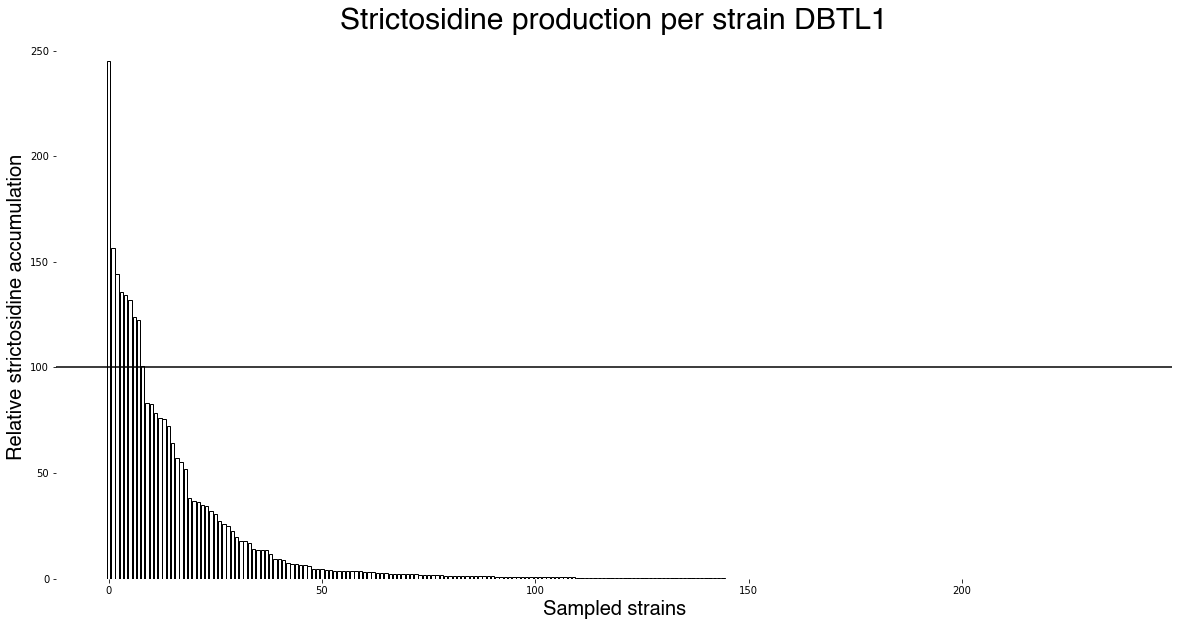

In [29]:
bar_plot(indexes, normalzed_strict , horisontal_line=True, save_pdf = True,
         path = 'G8H_CPR_library/data/10-plots/06_1_TEST_Library_characterization/Analysis of strictosidine per well in DBTL1 sorted', 
        title = 'Strictosidine production per strain DBTL1', 
        x_label= 'Sampled strains', 
        y_label= 'Relative strictosidine accumulation',
        size_height = 10, 
        size_length = 20) 

## 2.2 Genotyping

Purpose: Determine promoters from library strains to enable ML based sampling of library space

Methods:
DNA sequencing of assembled clusters. 


Genomic DNA was extracted from
overnight cultures using the LiOAc/SDS method adapted to a 96-well microtiter
plate format. Each extract was used as a template in 2 PCR reactions spanning
the 2 integrated promoter gene pairs and amplifying from 2500 to 3200 bp. The PCR
products were validated using a LabChip GX II (Perkin Elmer) and sequenced
using PlateSeq PCR Kits (Eurofins) according to the manufacturer’s instructions.
From the LabChip results, a PCR reaction was considered as trusted if it showed a
strong band of the correct size; not trusted if it showed a strong band of the wrong
size, and as no information (NI) gained if it showed a weak or no band. 


From the
sequencing results, a sequencing reaction was considered as trusted if it showed an
unambiguous sequence of the expected length (i.e., only limited by length of PCR
fragment, stretches of the same nucleotide in the promoter or of ~1 kb limit of
sanger sequencing reactions), not trusted if it showed an unambiguous sequence of
the expected length with an assembly error, and NI gained if there were no or bad
sequence results. If one or more sequencing results from the same strain showed
double peaks in the promoter region the strain was considered as a double
population. Finally, the promoter was noted as a failed assembly if either LabChip
and or sequencing results were considered not trusted, as NI if the sequencing
result was NI and else as the promoter predicted by pairwise alignment between
sequencing results and promoter sequence.

## 2.3 Sequencing


Eurofins     | SDP_ID | cassette
------------ | ------ | --------
PCR_00020195 | yp49   | g8h
PCR_00020204 | yp50   | g8h
PCR_00020205 | yp51   | g8h
PCR_00020206 | yp49   | cpr
PCR_00020207 | yp50   | cpr
PCR_00020208 | yp51   | cpr

In plateseq kits well h12 is reserved for quality control.
In all 6 plates yp49-51 for g8h & cpr well h12 contains medium control which do not need to be sequenced. Thus no need to rearrange samples.

In [30]:
path = 'G8H_CPR_library/data/08-sanger_sequencing/PlateSeq_files/'

In [31]:
yp49_cpr = pd.read_excel(path + 'PlateReport_yp49_cpr.xls')
yp49_g8h = pd.read_excel(path + 'PlateReport_yp49_g8h.xls')
yp50_cpr = pd.read_excel(path + 'PlateReport_yp50_cpr.xls')
yp50_g8h = pd.read_excel(path + 'PlateReport_yp50_g8h.xls')
yp51_cpr = pd.read_excel(path + 'PlateReport_yp51_cpr.xls')
yp51_g8h = pd.read_excel(path + 'PlateReport_yp51_g8h.xls')

# list of all the dataframes
sequencing_plates = [yp49_cpr, yp49_g8h, yp50_cpr, yp50_g8h, yp51_cpr, yp51_g8h]

In [32]:
from teemi.test.data_wrangling import slicing_and_naming_seq_plates, plat_seq_data_wrangler, plate_AvgQual, split_df_names, concatenating_list_of_dfs

### Data wrangling of plateSeq2 excel files

In [33]:
#Slicing plate data
sliced_plates = slicing_and_naming_seq_plates(sequencing_plates)

# Making the values numeric
list_of_dfs = plat_seq_data_wrangler(sliced_plates)

#filter them on their 
filtered_plates = plate_AvgQual(list_of_dfs)

# Split names
split_df = split_df_names(filtered_plates)

# concatenating the plates
all_data_frames = concatenating_list_of_dfs(split_df)

#merged_with_genotyping
all_data_frames

,Number,Sample-Name,AvgQual,Length,GoodQualFrom,GoodQualTo,used,plate,well
7,1,yp49_cpr_A1_pad_cpr_fw,57.51,1184,7.0,593.0,585,yp49,A1
9,3,yp49_cpr_C1_pad_cpr_fw,57.35,1097,6.0,591.0,584,yp49,C1
10,4,yp49_cpr_D1_pad_cpr_fw,57.43,1282,11.0,1057.0,1045,yp49,D1
11,5,yp49_cpr_E1_pad_cpr_fw,57.21,1192,5.0,594.0,588,yp49,E1
12,6,yp49_cpr_F1_pad_cpr_fw,57.00,1246,21.0,1097.0,1075,yp49,F1
...,...,...,...,...,...,...,...,...,...
60,54,yp51_g8h_D11_pad_g8h_fw,54.95,1206,14.0,1135.0,1120,yp51,D11
61,55,yp51_g8h_E11_pad_g8h_fw,57.72,1199,16.0,987.0,970,yp51,E11
62,56,yp51_g8h_A12_pad_g8h_fw,57.45,1167,18.0,987.0,968,yp51,A12
64,58,yp51_g8h_C12_pad_g8h_fw,57.46,1207,12.0,960.0,947,yp51,C12


In [34]:
## Adding a zero to all the numers before 10
wells = []
for index, row in all_data_frames.iterrows():
    if len(row['well']) == 2: 
        letter, number = row['well'][0:1], row['well'][1:2]
        #print(letter, number)
        row['well'] = letter + '0' + number
        wells.append(row['well'])
    else: 
        wells.append(row['well'])
        
all_data_frames['well'] = wells
all_data_frames

,Number,Sample-Name,AvgQual,Length,GoodQualFrom,GoodQualTo,used,plate,well
7,1,yp49_cpr_A1_pad_cpr_fw,57.51,1184,7.0,593.0,585,yp49,A01
9,3,yp49_cpr_C1_pad_cpr_fw,57.35,1097,6.0,591.0,584,yp49,C01
10,4,yp49_cpr_D1_pad_cpr_fw,57.43,1282,11.0,1057.0,1045,yp49,D01
11,5,yp49_cpr_E1_pad_cpr_fw,57.21,1192,5.0,594.0,588,yp49,E01
12,6,yp49_cpr_F1_pad_cpr_fw,57.00,1246,21.0,1097.0,1075,yp49,F01
...,...,...,...,...,...,...,...,...,...
60,54,yp51_g8h_D11_pad_g8h_fw,54.95,1206,14.0,1135.0,1120,yp51,D11
61,55,yp51_g8h_E11_pad_g8h_fw,57.72,1199,16.0,987.0,970,yp51,E11
62,56,yp51_g8h_A12_pad_g8h_fw,57.45,1167,18.0,987.0,968,yp51,A12
64,58,yp51_g8h_C12_pad_g8h_fw,57.46,1207,12.0,960.0,947,yp51,C12


In [35]:
concating_all_plates_with_bad_reads = concatenating_list_of_dfs(sequencing_plates)
concating_all_plates_with_bad_reads = concating_all_plates_with_bad_reads.replace('n.a.', np.NaN)
concating_all_plates_with_bad_reads = split_df_names([concating_all_plates_with_bad_reads])[0]
concating_all_plates_with_bad_reads

,Number,Sample-Name,AvgQual,Length,GoodQualFrom,GoodQualTo,used,plate,well
7,1,yp49_cpr_A1_pad_cpr_fw,57.51,1184,7.0,593.0,585,yp49,A1
8,2,yp49_cpr_B1_pad_cpr_fw,19.63,1029,115.0,144.0,28,yp49,B1
9,3,yp49_cpr_C1_pad_cpr_fw,57.35,1097,6.0,591.0,584,yp49,C1
10,4,yp49_cpr_D1_pad_cpr_fw,57.43,1282,11.0,1057.0,1045,yp49,D1
11,5,yp49_cpr_E1_pad_cpr_fw,57.21,1192,5.0,594.0,588,yp49,E1
...,...,...,...,...,...,...,...,...,...
62,56,yp51_g8h_A12_pad_g8h_fw,57.45,1167,18.0,987.0,968,yp51,A12
63,57,yp51_g8h_B12_pad_g8h_fw,18.65,1188,453.0,472.0,18,yp51,B12
64,58,yp51_g8h_C12_pad_g8h_fw,57.46,1207,12.0,960.0,947,yp51,C12
65,59,yp51_g8h_D12_pad_g8h_fw,28.14,1213,534.0,602.0,67,yp51,D12


### Detailed check of assemblies
- Manuel filtering. trusted / not_trusted ab1. 
- For certains strains multiple ab1 sequences get ambiguous only in promoters -> double population
- ab1 sequences quality drops preliminary due to stretches of same nucleotides in certain promoters  -> trusted even though small seq alignment 
- Low quality ab1 -> not_trusted


In [36]:
manual_checked = pd.read_excel('G8H_CPR_library/data/08-sanger_sequencing/manual_check/sequence_check_yp49_51.xlsx')
manual_checked.head(10)

,plate,well,position,inf_promoter,ab1,ab1_comment,gel,gel_comment,if a larger part of the gene was not aligned due to N's,second alignment,Keep,Info
0,yp49,A01,2,5.0,good,good,good,good,NaN,NaN,True,"""-"" = empty"
1,yp49,A01,1,2.0,good,good,good,good,NaN,NaN,True,bad = not ambigous but does not align with pro...
2,yp49,A02,2,8.0,good,good,good,weak,NaN,NaN,True,bad = not ambigous but does not align with pro...
3,yp49,A02,1,3.0,good,good,good,good,NaN,NaN,True,NaN
4,yp49,A03,2,8.0,good,good,good,good,NaN,NaN,True,NaN
5,yp49,A03,1,3.0,good,good,good,good,NaN,NaN,True,NaN
6,yp49,A04,2,8.0,good,good,no_information,no_information,NaN,NaN,True,NaN
7,yp49,A04,1,3.0,good,good,good,good,NaN,NaN,True,NaN
8,yp49,A05,2,NaN,no_information,no_information,no_information,no_information,NaN,NaN,False,NaN
9,yp49,A05,1,3.0,good,good,good,good,NaN,NaN,True,NaN


Lets parse through the file and add the sequences to the all_sequences dataframe 

In [37]:
df_filterd_keep = manual_checked[manual_checked['Keep'] == True]

In [38]:
# making Sample-name from the information above
sample_names = []
for index, row in df_filterd_keep.iterrows():
    if row['position'] == 1:
        name = 'g8h'
    if row['position'] == 2:
        name = 'cpr'
    
    # Getting the right nomeclature
    if row['well'][1] == '0': 
        well = row['well'][0]+row['well'][2]  
    else: 
        well = row['well']

    sample_name = f"{row['plate']}_{name}_{well}_pad_{name}_fw"
    sample_names.append(sample_name)
    
df_filterd_keep['Sample-Name'] = sample_names
df_filterd_keep['Line_name'] = df_filterd_keep['plate']+'_'+df_filterd_keep['well']

/var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/ipykernel_7114/4175909723.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filterd_keep['Sample-Name'] = sample_names
/var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/ipykernel_7114/4175909723.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filterd_keep['Line_name'] = df_filterd_keep['plate']+'_'+df_filterd_keep['well']


In [39]:
df_filterd_keep.head()

,plate,well,position,inf_promoter,ab1,ab1_comment,gel,gel_comment,if a larger part of the gene was not aligned due to N's,second alignment,Keep,Info,Sample-Name,Line_name
0,yp49,A01,2,5.0,good,good,good,good,NaN,NaN,True,"""-"" = empty",yp49_cpr_A1_pad_cpr_fw,yp49_A01
1,yp49,A01,1,2.0,good,good,good,good,NaN,NaN,True,bad = not ambigous but does not align with pro...,yp49_g8h_A1_pad_g8h_fw,yp49_A01
2,yp49,A02,2,8.0,good,good,good,weak,NaN,NaN,True,bad = not ambigous but does not align with pro...,yp49_cpr_A2_pad_cpr_fw,yp49_A02
3,yp49,A02,1,3.0,good,good,good,good,NaN,NaN,True,NaN,yp49_g8h_A2_pad_g8h_fw,yp49_A02
4,yp49,A03,2,8.0,good,good,good,good,NaN,NaN,True,NaN,yp49_cpr_A3_pad_cpr_fw,yp49_A03


In [40]:
# Sample-Name	inf_part_name	align_score	inf_part_number
df_filterd_keep = df_filterd_keep[['Sample-Name', 'inf_promoter', 'Line_name', 'position']]
df_filterd_keep.columns = ['Sample-Name', 'inf_part_number', 'Line_name','position']
df_filterd_keep.head()

,Sample-Name,inf_part_number,Line_name,position
0,yp49_cpr_A1_pad_cpr_fw,5.0,yp49_A01,2
1,yp49_g8h_A1_pad_g8h_fw,2.0,yp49_A01,1
2,yp49_cpr_A2_pad_cpr_fw,8.0,yp49_A02,2
3,yp49_g8h_A2_pad_g8h_fw,3.0,yp49_A02,1
4,yp49_cpr_A3_pad_cpr_fw,8.0,yp49_A03,2


## 2.4 Infering promoter to sample relationship

#### Primers used

In [41]:
from Bio import SeqIO

In [42]:
from teemi.lims.csv_database import get_dna_from_box_name

In [43]:
pad_pG8H_fw = get_dna_from_box_name('pad_pG8H_fw', 'primer_box', database_path = 'G8H_CPR_library/data/06-lims/csv_database/')
pad_pCPR_fw = get_dna_from_box_name('pad_pCPR_fw', 'primer_box', database_path = 'G8H_CPR_library/data/06-lims/csv_database/')

In [44]:
primers_for_seq = [pad_pG8H_fw, pad_pCPR_fw]
primers_for_seq

[SeqRecord(seq=Seq('TGCCCATTCGATAAGGCA'), id='10148.0', name='pad_pG8H_fw', description='Stock of primers for G8H-CPR library ', dbxrefs=[]),
 SeqRecord(seq=Seq('GGCGTATGGACCTGTCT'), id='10144.0', name='pad_pCPR_fw', description='Stock of primers for G8H-CPR library ', dbxrefs=[])]

#### Promoters to be aligned

In [45]:
pG8H_template_names = ['pCYC1','pENO2','pPCK1','pRPL15B']
pCPR_template_names = ['pCCW12','pMLS1','pTPI1','pURE2']

In [46]:
path = 'G8H_CPR_library/data/06-lims/csv_database/'
genbank_path = 'G8H_CPR_library/data/06-lims/genbank_files/'

pG8H_sites =[get_dna_from_box_name(name, 'ds_dna_box', database_path = path,genbank = True, genbank_files_path = genbank_path) for name in pG8H_template_names]  
pCPR_sites =[get_dna_from_box_name(name, 'ds_dna_box', database_path = path, genbank = True, genbank_files_path = genbank_path) for name in pCPR_template_names]  

In [47]:
templates = pCPR_sites+pG8H_sites

#### ab1 reads to be analysed

In [48]:
path = 'G8H_CPR_library/data/08-sanger_sequencing/sanger_seq_files/ab1_yp49_51/'
files = os.listdir(path)
print(len(files))
reads = []
for read in files:
    if read.endswith('ab1'): 
        reads.append(SeqIO.read(path+read, 'abi'))

500


In [49]:
reads[12]

SeqRecord(seq=Seq('NNNNNNNNNNNGTANTGANNGGCTACCAAAAACGATAATCTCAACTGTAAACAG...NAA'), id='A-352518_F7', name='yp50_cpr_F7_pad_cpr_fw', description='', dbxrefs=[])

## 2.5 Aligning promoters to reads - infer promoter alignment

In [50]:
list_of_promoters = ["pCYC1", "pENO2","pPCK1","pRPL15B", "pCCW12", "pTPI1","pMLS1","pURE2"]
numbers_list = [5, 7,6, 8, 1, 2, 3, 4]

for i in range(len(templates)): 
    templates[i].description = numbers_list[i]
    
templates

[SeqRecord(seq=Seq('AAAGAAACTTAATACGTTATGCCGTAATGAAGGGCTACCAAAAACGATAATCTC...ATA'), id='10037', name='pCCW12', description=5, dbxrefs=[]),
 SeqRecord(seq=Seq('TTTAATCTTTAGGGAGGGTAAAGTTGGATTCATCAATTTGATGAAATCCGTGTA...AAA'), id='10038', name='pMLS1', description=7, dbxrefs=[]),
 SeqRecord(seq=Seq('AAGGATGAGCCAAGAATAAGGGAACAAGATTTTGGTAATTTCCAAAAAATCAAT...AAA'), id='10039', name='pTPI1', description=6, dbxrefs=[]),
 SeqRecord(seq=Seq('CAAGCTGAACTCGCTGAAATTGAAAGAAAACTGGCAGAATCGTCTTCTGAAGAC...CAA'), id='10040', name='pURE2', description=8, dbxrefs=[]),
 SeqRecord(seq=Seq('CAGCATTTTCAAAGGTGTGTTCTTCGTCAGACATGTTTTAGTGTGTGAATGAAA...ATA'), id='10033', name='pCYC1', description=1, dbxrefs=[]),
 SeqRecord(seq=Seq('AATCCTACTCTTGCCGTTGCCATCCAAAATGAGCTAGAAGGTGGATTAACAAAT...ATA'), id='10034', name='pENO2', description=2, dbxrefs=[]),
 SeqRecord(seq=Seq('CACATGTCGACGAGTTTGTCATCGAATCCGTAATGAAGGCGCAAGAAAAACTAG...AAC'), id='10035', name='pPCK1', description=3, dbxrefs=[]),
 SeqRecord(seq=Seq('GTACTGCTGGCCA

In [51]:
# lets limit the alingment to only reads that are of proper quality
sample_names = df_filterd_keep['Sample-Name'].tolist()

good_samples = []
for i in range(len(reads)):
    for j in range(len(sample_names)): 
        if reads[i].name == sample_names[j]: 
            good_samples.append(reads[i])
            
len(good_samples)

381

## 2.6 Aligning the reads to the templates

Now we can use the function pairwise_alignment_of_templates to infer relationship to the promoter we have in our genetic constructs. 

In [52]:
from teemi.test.genotyping import pairwise_alignment_of_templates

In [53]:
%%time
df_alignment = pairwise_alignment_of_templates(good_samples,templates, primers_for_seq)
df_alignment

CPU times: user 18.5 s, sys: 161 ms, total: 18.7 s
Wall time: 18.7 s


,Sample-Name,inf_part_name,align_score,inf_part_number
0,yp51_cpr_C2_pad_cpr_fw,pCCW12,751.0,5
1,yp49_g8h_D3_pad_g8h_fw,pPCK1,973.0,3
2,yp49_g8h_E6_pad_g8h_fw,pENO2,932.0,2
3,yp50_cpr_B12_pad_cpr_fw,pMLS1,964.0,7
4,yp51_cpr_E6_pad_cpr_fw,pMLS1,973.0,7
...,...,...,...,...
376,yp49_cpr_B10_pad_cpr_fw,pURE2,975.0,8
377,yp49_cpr_F11_pad_cpr_fw,pMLS1,968.0,7
378,yp49_cpr_A6_pad_cpr_fw,pTPI1,968.0,6
379,yp50_g8h_D3_pad_g8h_fw,pENO2,960.0,2


In [54]:
col_list =  list(df_alignment["align_score"])
print(col_list)

[751.0, 973.0, 932.0, 964.0, 973.0, 509.0, 966.0, 892.0, 968.0, 970.0, 518.0, 951.0, 525.0, 951.0, 503.0, 967.0, 859.0, 504.0, 968.0, 955.0, 966.0, 526.0, 972.0, 969.0, 970.0, 954.0, 969.0, 539.0, 959.0, 972.0, 972.0, 466.0, 949.0, 940.0, 444.0, 954.0, 968.0, 957.0, 756.0, 518.0, 679.0, 968.0, 933.0, 955.0, 544.0, 836.0, 955.0, 955.0, 870.0, 968.0, 856.0, 500.0, 501.0, 974.0, 912.0, 866.0, 793.0, 777.0, 785.0, 969.0, 308.0, 948.0, 969.0, 967.0, 950.0, 936.0, 955.0, 809.0, 970.0, 948.0, 532.0, 969.0, 680.0, 531.0, 838.0, 971.0, 967.0, 955.0, 948.0, 973.0, 527.0, 962.0, 955.0, 954.0, 961.0, 969.0, 918.0, 518.0, 751.0, 956.0, 951.0, 748.0, 971.0, 848.0, 969.0, 907.0, 831.0, 970.0, 970.0, 977.0, 971.0, 970.0, 954.0, 959.0, 949.0, 964.0, 953.0, 850.0, 969.0, 971.0, 516.0, 972.0, 956.0, 969.0, 531.0, 964.0, 936.0, 793.0, 959.0, 955.0, 518.0, 950.0, 529.0, 953.0, 964.0, 926.0, 734.0, 949.0, 973.0, 968.0, 972.0, 972.0, 485.0, 955.0, 810.0, 974.0, 794.0, 951.0, 973.0, 512.0, 964.0, 748.0, 954.0

In [55]:
minvalue = df_alignment['align_score'].min()
minvalue

308.0

In [56]:
df_align_sort = df_alignment.sort_values(['Sample-Name'])
df_align_sort.head()

,Sample-Name,inf_part_name,align_score,inf_part_number
157,yp49_cpr_A12_pad_cpr_fw,pMLS1,965.0,7
357,yp49_cpr_A1_pad_cpr_fw,pCCW12,833.0,5
252,yp49_cpr_A2_pad_cpr_fw,pURE2,972.0,8
242,yp49_cpr_A3_pad_cpr_fw,pURE2,973.0,8
222,yp49_cpr_A4_pad_cpr_fw,pURE2,881.0,8


In [57]:
df_alignment['position'] = ''
position = []
for index, row in df_alignment.iterrows():
    split = str(row['Sample-Name'].split("_")[1])
    if split == 'g8h': 
        position.append(1)
    if split == 'cpr': 
        position.append(2)

df_alignment['position'] = position
df_alignment.head()

,Sample-Name,inf_part_name,align_score,inf_part_number,position
0,yp51_cpr_C2_pad_cpr_fw,pCCW12,751.0,5,2
1,yp49_g8h_D3_pad_g8h_fw,pPCK1,973.0,3,1
2,yp49_g8h_E6_pad_g8h_fw,pENO2,932.0,2,1
3,yp50_cpr_B12_pad_cpr_fw,pMLS1,964.0,7,2
4,yp51_cpr_E6_pad_cpr_fw,pMLS1,973.0,7,2


grouping the positions

In [58]:
grouped = df_alignment.groupby(df_alignment.position)
g8h_df = grouped.get_group(1)
cpr_df = grouped.get_group(2)

g8h_df.head()

,Sample-Name,inf_part_name,align_score,inf_part_number,position
1,yp49_g8h_D3_pad_g8h_fw,pPCK1,973.0,3,1
2,yp49_g8h_E6_pad_g8h_fw,pENO2,932.0,2,1
5,yp49_g8h_B7_pad_g8h_fw,pCYC1,509.0,1,1
6,yp49_g8h_C2_pad_g8h_fw,pPCK1,966.0,3,1
10,yp49_g8h_G12_pad_g8h_fw,pCYC1,518.0,1,1


In [59]:
cpr_df.head()

,Sample-Name,inf_part_name,align_score,inf_part_number,position
0,yp51_cpr_C2_pad_cpr_fw,pCCW12,751.0,5,2
3,yp50_cpr_B12_pad_cpr_fw,pMLS1,964.0,7,2
4,yp51_cpr_E6_pad_cpr_fw,pMLS1,973.0,7,2
7,yp50_cpr_F7_pad_cpr_fw,pCCW12,892.0,5,2
8,yp50_cpr_G2_pad_cpr_fw,pURE2,968.0,8,2


In [60]:
# lets merge the quality dataframe
infered_promoters_df = pd.merge(concating_all_plates_with_bad_reads, df_alignment, left_on=['Sample-Name'], right_on = ['Sample-Name'])

In [61]:
infered_promoters_df.head()

,Number,Sample-Name,AvgQual,Length,GoodQualFrom,GoodQualTo,used,plate,well,inf_part_name,align_score,inf_part_number,position
0,1,yp49_cpr_A1_pad_cpr_fw,57.51,1184,7.0,593.0,585,yp49,A1,pCCW12,833.0,5,2
1,3,yp49_cpr_C1_pad_cpr_fw,57.35,1097,6.0,591.0,584,yp49,C1,pCCW12,793.0,5,2
2,4,yp49_cpr_D1_pad_cpr_fw,57.43,1282,11.0,1057.0,1045,yp49,D1,pMLS1,972.0,7,2
3,5,yp49_cpr_E1_pad_cpr_fw,57.21,1192,5.0,594.0,588,yp49,E1,pCCW12,836.0,5,2
4,6,yp49_cpr_F1_pad_cpr_fw,57.00,1246,21.0,1097.0,1075,yp49,F1,pTPI1,969.0,6,2


#### Comparing to the manually currated dataframe

In [62]:
indexes = []
new_inf_part = []
# manually curated
for index, row in df_filterd_keep.iterrows():
    
    # best pairwise alignment
    for index1, row1 in infered_promoters_df.iterrows():
        if row['Sample-Name'] == row1['Sample-Name']:
            if int(row['inf_part_number']) != int(row1['inf_part_number']):
                print('Not matching', row['inf_part_number'] , row1['inf_part_number'] , row['Sample-Name'] , row1['Sample-Name'])
                
                indexes.append(index1)
                new_inf_part.append(int(row['inf_part_number']))
                ## changing it to the manually curated one
                #infered_promoters_df.loc[index1].at['inf_part_number'] = 2
                #print('No match', row['inf_part_number'] , row1['inf_part_number'])


Not matching 2.0 7 yp51_g8h_D12_pad_g8h_fw yp51_g8h_D12_pad_g8h_fw


In [63]:
# changing that 
infered_promoters_df1 = infered_promoters_df.copy(deep=True)
infered_promoters_df1['inf_part_number'][indexes[0]] = 2

/var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/ipykernel_7114/3119800932.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  infered_promoters_df1['inf_part_number'][indexes[0]] = 2


In [64]:
infered_promoters_df = infered_promoters_df1[["plate", "well", "inf_part_number", "position"]]
infered_promoters_df.head()

,plate,well,inf_part_number,position
0,yp49,A1,5,2
1,yp49,C1,5,2
2,yp49,D1,7,2
3,yp49,E1,5,2
4,yp49,F1,6,2


In [65]:
well_list = infered_promoters_df['well'].to_list()

new_well_list = []
for i in range(len(well_list)): 
    if len(well_list[i]) == 2:
        
        well = str(well_list[i][0:1])+'0'+str(well_list[i][1:2])
        new_well_list.append(well)
        well= ''
        
    else: 
        new_well_list.append(well_list[i])

infered_promoters_df['well'] = new_well_list
infered_promoters_df.head()

/var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/ipykernel_7114/64002291.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  infered_promoters_df['well'] = new_well_list


,plate,well,inf_part_number,position
0,yp49,A01,5,2
1,yp49,C01,5,2
2,yp49,D01,7,2
3,yp49,E01,5,2
4,yp49,F01,6,2


In [66]:
# grouping
grouped = infered_promoters_df.groupby(infered_promoters_df.position)
g8h_df = grouped.get_group(1)
cpr_df = grouped.get_group(2)

#filtering
g8h_df = g8h_df[["plate", "well", "inf_part_number"]]
cpr_df = cpr_df[["plate", "well", "inf_part_number"]]

# changing names
g8h_df.columns = ['plate', 'well', 'inf_promoter1']
cpr_df.columns = ['plate', 'well', 'inf_promoter2']

promoter_to_well = pd.merge(g8h_df, cpr_df, left_on=['plate','well' ], right_on = ['plate','well'])
promoter_to_well.head()

,plate,well,inf_promoter1,inf_promoter2
0,yp49,A01,2,5
1,yp49,C01,2,5
2,yp49,D01,4,7
3,yp49,E01,1,5
4,yp49,F01,3,6


In [67]:
print(len(g8h_df))
print(len(cpr_df))

218
163


Sanity check - did we get the correct promoters in each well? 


In [68]:
for index, row in promoter_to_well.iterrows():
    if int(row['inf_promoter1']) > 4:
        print('SOMTHING WRONG WITH G8H', row['plate'], row['well'], index,row['inf_promoter1'])
    if int(row['inf_promoter2']) < 5:
            print('SOMTHING WRONG WITH CPR', row['plate'], row['well'], index)
print('SUCCESSSSS')


SUCCESSSSS


## 2.7 Re-sequencing 

As shown above, we lose alot of samples because many of the CPR samples did not meet the quality criteria. Therefore we re-sequenced some of the samples again. 

In [69]:
re_sequenced = pd.read_excel('G8H_CPR_library/data/08-sanger_sequencing/PlateSeq_files/PlateReport_re_sequenced_yp49-51.xls')

# we can filter out the samples we need by only using samples with well not NAN
re_sequenced = re_sequenced[re_sequenced['Well'].notna()]
re_sequenced.head()

,Box,Tube Code,Rack Position,Strain,Primer,Date submitted,Results,Comment,Sample,Well
33,EF0000042207,EF20047945,C10,HA-43_F09_Rsep Ara_3 yp50 F09,pad_pG8H_fw,2021-08-20 00:00:00,NaN,ExoSAP,yp50,F09
34,EF0000042208,EF20047946,C11,HA-42_F05_Rsep Aan_2 yp50 F05,pad_pG8H_fw,2021-08-20 00:00:00,NaN,ExoSAP,yp50,F05
35,EF0000042209,EF20047947,C12,HA-39_E07_Smus Oeu_1 yp50 E07,pad_pG8H_fw,2021-08-20 00:00:00,NaN,ExoSAP,yp50,E07
36,EF0000042210,EF20047948,D1,HA-83_A08_Oeu Ara_2 yp51 A08,pad_pCPR_fw,2021-08-20 00:00:00,NaN,ExoSAP,yp51,A08
37,EF0000042211,EF20047949,D2,HA-82_A06_Oeu Aan_3 yp51 A06,pad_pCPR_fw,2021-08-20 00:00:00,NaN,ExoSAP,yp51,A06


Importing the ab1 files

In [70]:
path = 'G8H_CPR_library/data/08-sanger_sequencing/sanger_seq_files/ab1_yp49_51_resequencing/'
files = os.listdir(path)

reads_reseq = []
for read in files:
    if read.endswith('ab1'): 
        reads_reseq.append(SeqIO.read(path+read, 'abi'))
        
print(len(reads_reseq))

40


In [71]:
reads_reseq[0]

SeqRecord(seq=Seq('CAACGTAGGGGGAAAGAAGGGCTTACCAAAAACGATAATCTCAACTGTAAACAG...AGG'), id='EF20047981', name='EF20047981_EF20047981', description='', dbxrefs=[])

In [72]:
# cross-ref the tube-codes
tube_codes = list(re_sequenced['Tube Code'])

In [73]:
# checking the reads match
i = 0
for name in reads_reseq: 
    if name.id not in tube_codes: 
        print(name.id)
    # the names for the reads are written like "id_id". we'll overwrite.
    name.name = name.id
i

0

In [74]:
reads_reseq[0]

SeqRecord(seq=Seq('CAACGTAGGGGGAAAGAAGGGCTTACCAAAAACGATAATCTCAACTGTAAACAG...AGG'), id='EF20047981', name='EF20047981', description='', dbxrefs=[])

In [75]:
%%time
df_alignment_reseq = pairwise_alignment_of_templates(reads_reseq,templates, primers_for_seq)

CPU times: user 2.3 s, sys: 39.4 ms, total: 2.34 s
Wall time: 2.36 s


In [76]:
df_alignment_reseq.head()

,Sample-Name,inf_part_name,align_score,inf_part_number
0,EF20047981,pCCW12,908.0,5
1,EF20047978,pTPI1,953.0,6
2,EF20047987,pCCW12,799.0,5
3,EF20047958,pURE2,981.0,8
4,EF20047980,pURE2,968.0,8


#### merging df_alignment_reseq and re-sequenced 

In [77]:
promoter_to_well_reseq = pd.merge( df_alignment_reseq,re_sequenced, left_on=['Sample-Name' ], right_on = ['Tube Code'])
len(promoter_to_well_reseq)

40

Getting the positions ie. g8h or cpr

In [78]:
positions =list(promoter_to_well_reseq['Primer'])
positions_for_df = []
for position in positions: 
    if position == 'pad_pCPR_fw': 
        positions_for_df.append(2)
    if position == 'pad_pG8H_fw': 
        positions_for_df.append(1)
promoter_to_well_reseq['position'] = positions_for_df

In [79]:
promoter_to_well_reseq.head()

,Sample-Name,inf_part_name,align_score,inf_part_number,Box,Tube Code,Rack Position,Strain,Primer,Date submitted,Results,Comment,Sample,Well,position
0,EF20047981,pCCW12,908.0,5,EF0000042239,EF20047981,F6,HA-39_E08_Smus Oeu_2 yp50 E08,pad_pCPR_fw,2021-08-20 00:00:00,NaN,Washed with ethanol,yp50,E08,2
1,EF20047978,pTPI1,953.0,6,EF0000042236,EF20047978,F3,HA-45_G03_Rsep Rse_3 yp50 G0,pad_pCPR_fw,2021-08-20 00:00:00,NaN,Washed with ethanol,yp50,G0,2
2,EF20047987,pCCW12,799.0,5,EF0000042243,EF20047987,F10,HA-32_C12_Smus Aan_3 yp50 C12,pad_pCPR_fw,2021-08-20 00:00:00,NaN,Washed with ethanol,yp50,C12,2
3,EF20047958,pURE2,981.0,8,EF0000042218,EF20047958,D9,HA-42_F04_Rsep Aan_1 yp50 F04,pad_pCPR_fw,2021-08-20 00:00:00,NaN,ExoSAP,yp50,F04,2
4,EF20047980,pURE2,968.0,8,EF0000042238,EF20047980,F5,HA-42_F04_Rsep Aan_1 yp50 F04,pad_pCPR_fw,2021-08-20 00:00:00,NaN,Washed with ethanol,yp50,F04,2


In [80]:
promoter_to_well_reseq_filtered = promoter_to_well_reseq[['Sample', 'Well', 'inf_part_number', 'position']]
promoter_to_well_reseq_filtered.columns = ['plate', 'well', 'inf_part_number', 'position']
promoter_to_well_reseq_filtered['Line_name'] = promoter_to_well_reseq_filtered['plate']+'_'+promoter_to_well_reseq_filtered['well']
promoter_to_well_reseq_filtered.head()

/var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/ipykernel_7114/823718168.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  promoter_to_well_reseq_filtered['Line_name'] = promoter_to_well_reseq_filtered['plate']+'_'+promoter_to_well_reseq_filtered['well']


,plate,well,inf_part_number,position,Line_name
0,yp50,E08,5,2,yp50_E08
1,yp50,G0,6,2,yp50_G0
2,yp50,C12,5,2,yp50_C12
3,yp50,F04,8,2,yp50_F04
4,yp50,F04,8,2,yp50_F04


#### manual curation

In [81]:
indexes = []

for index, row in promoter_to_well_reseq_filtered.iterrows():
    for index1, row1 in df_filterd_keep.iterrows():
        if row['Line_name'] == row1['Line_name'] and row['position'] == row1['position'] and int(row['inf_part_number']) != int(row1['position']):
            print()
            print('Problem')

In [82]:
# concatenating with our previous dataframe 
infered_promoters_df = pd.concat([infered_promoters_df,promoter_to_well_reseq_filtered])
infered_promoters_df.tail()
print(len(infered_promoters_df))

421


In [83]:
# grouping
grouped = infered_promoters_df.groupby(infered_promoters_df.position)
g8h_df = grouped.get_group(1)
cpr_df = grouped.get_group(2)

#filtering
g8h_df = g8h_df[["plate", "well", "inf_part_number"]]
cpr_df = cpr_df[["plate", "well", "inf_part_number"]]

# changing names
g8h_df.columns = ['plate', 'well', 'inf_promoter1']
cpr_df.columns = ['plate', 'well', 'inf_promoter2']

promoter_to_well = pd.merge(g8h_df, cpr_df, left_on=['plate','well' ], right_on = ['plate','well'])
print(len(promoter_to_well))
promoter_to_well.head()

189


,plate,well,inf_promoter1,inf_promoter2
0,yp49,A01,2,5
1,yp49,C01,2,5
2,yp49,D01,4,7
3,yp49,E01,1,5
4,yp49,F01,3,6


In [84]:
promoter_to_well = promoter_to_well.drop_duplicates(ignore_index = True)
len(promoter_to_well)

172

In [85]:
df_filterd_keep.head()

,Sample-Name,inf_part_number,Line_name,position
0,yp49_cpr_A1_pad_cpr_fw,5.0,yp49_A01,2
1,yp49_g8h_A1_pad_g8h_fw,2.0,yp49_A01,1
2,yp49_cpr_A2_pad_cpr_fw,8.0,yp49_A02,2
3,yp49_g8h_A2_pad_g8h_fw,3.0,yp49_A02,1
4,yp49_cpr_A3_pad_cpr_fw,8.0,yp49_A03,2


# 3. Combine data


In [86]:
promoter_genotype_relationship = pd.merge(promoter_to_well, sorted_df_lcms, on=['plate','well' ])
len(promoter_genotype_relationship)

169

### adding the enzyme genotypes

In [87]:
g8h_list_of_index = ["CacuG8H", "OpumG8H","CroG8H","VminG8H","SmusG8H","RsepG8H","OeuG8H","CcalG8H"]
cpr_list_of_index = ["CroCPR", "AanCPR","AraCPR","CloCPR","RseCPR","AhuCPR","AniCPR","CacCPR","OeuCPR","CpoCPR"]

g8h_genotype = []
cpr_genotype = []

# adding index of genotypes to individual rows 
for index, row in promoter_genotype_relationship.iterrows():
    g8h_geno = str(row['genotype'].split(" ")[0])
    cpr_geno = str(row['genotype'].split(" ")[1])
    
    
    g8h_pos = g8h_list_of_index.index(str(row['genotype'].split(" ")[0]))+1
    cpr_pos = cpr_list_of_index.index(str(row['genotype'].split(" ")[1]))+1

    
    g8h_genotype.append(g8h_pos)
    cpr_genotype.append(cpr_pos)
    
promoter_genotype_relationship['G8H'] = g8h_genotype
promoter_genotype_relationship['CPR'] = cpr_genotype

In [88]:
promoter_genotype_relationship['Line_name'] = promoter_genotype_relationship['plate']+ '_'+ promoter_genotype_relationship['well']

In [89]:
promoter_genotype_relationship.head()

,plate,well,inf_promoter1,inf_promoter2,index,data_file,sample_notes,Amt_uM_Loganic acid,Amt_uM_Loganin,Amt_uM_Secologanin,...,Amt_uM_Tryptamine,sample,strain,col_no,genotype,medium,norm_strict_%,G8H,CPR,Line_name
0,yp49,A01,2,5,0,210519_TMET517_018.xms,96WP1056_A01,0.0,0.00000,0.0,...,916.816821,96WP1056,MIA-HA-51,1.0,CacuG8H CroCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol,0.922793,1,1,yp49_A01
1,yp49,C01,2,5,22,210519_TMET517_044.xms,96WP1056_C01,0.0,0.00000,0.0,...,853.179516,96WP1056,MIA-HA-59,1.0,CacuG8H OeuCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol,0.509123,1,9,yp49_C01
2,yp49,D01,4,7,34,210519_TMET517_057.xms,96WP1056_D01,0.0,0.00000,0.0,...,746.480964,96WP1056,MIA-HA-63,1.0,OpumG8H AraCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol,0.166871,2,3,yp49_D01
3,yp49,E01,1,5,46,210519_TMET517_083.xms,96WP1056_E01,0.0,0.00000,0.0,...,766.625577,96WP1056,MIA-HA-67,1.0,OpumG8H AniCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol,0.327489,2,7,yp49_E01
4,yp49,F01,3,6,58,210519_TMET517_096.xms,96WP1056_F01,0.0,1.35041,0.0,...,621.345993,96WP1056,MIA-HA-71,1.0,CroG8H CroCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol,25.060934,3,1,yp49_F01


In [90]:
promoter_genotype_relationship = promoter_genotype_relationship[['Line_name', 'G8H','inf_promoter1', 'inf_promoter2', 'CPR', 'Amt_uM_Strictosidine',   'norm_strict_%']]
promoter_genotype_relationship.columns = ['Line_name',  '0','1', '2', '3','Amt_uM_Strictosidine', 'Amt_norm']

In [91]:
#find duplicate rows across all columns
duplicateRows = promoter_genotype_relationship[promoter_genotype_relationship.duplicated(['Line_name'], keep=False)]
print(len(duplicateRows))
print(duplicateRows)

2
   Line_name  0  1  2  3  Amt_uM_Strictosidine  Amt_norm
22  yp49_G04  3  2  6  6              1.188821  4.045133
23  yp49_G04  3  2  7  6              1.188821  4.045133


We cannot trust this ambiguity and will therefore drop the duplicated rows

In [92]:
promoter_genotype_relationship = promoter_genotype_relationship.drop_duplicates(subset = 'Line_name', keep=False)
promoter_genotype_relationship

,Line_name,0,1,2,3,Amt_uM_Strictosidine,Amt_norm
0,yp49_A01,1,2,5,1,0.271199,0.922793
1,yp49_C01,1,2,5,9,0.149626,0.509123
2,yp49_D01,2,4,7,3,0.049042,0.166871
3,yp49_E01,2,1,5,7,0.096246,0.327489
4,yp49_F01,3,3,6,1,7.365141,25.060934
...,...,...,...,...,...,...,...
164,yp51_C12,8,3,7,2,0.000000,0.000000
165,yp51_D12,8,2,7,6,0.202343,0.591185
166,yp51_E12,8,1,6,10,0.153556,0.448644
167,yp50_F05,6,1,8,2,4.656777,13.391244


### How many unique genotypes did we get in this round? 

In [93]:
test_identical_rows = promoter_genotype_relationship[['0', '1','2','3']]

# find identical genotypes
bool_series = promoter_genotype_relationship.duplicated(subset=['0', '1','2','3'])

#  Count True values - this only counts true values
counts = bool_series.sum()
print(f'Unique genotypes from this DBTL round {len(promoter_genotype_relationship)-counts}')
print(f'Coverage of the whole library: {((len(promoter_genotype_relationship)-counts)/1280)*100}%')

Unique genotypes from this DBTL round 159
Coverage of the whole library: 12.421875%


#### Export file

In [94]:
promoter_genotype_relationship.to_csv('G8H_CPR_library/data/09-AutoML/input_to_ml/first_round/input_for_ml_1st_iteration_all_analytics.csv',index=False )

In [95]:
input_for_ml = pd.read_csv('G8H_CPR_library/data/09-AutoML/input_to_ml/first_round/input_for_ml_1st_iteration_all_analytics.csv', index_col=None)
input_for_ml

,Line_name,0,1,2,3,Amt_uM_Strictosidine,Amt_norm
0,yp49_A01,1,2,5,1,0.271199,0.922793
1,yp49_C01,1,2,5,9,0.149626,0.509123
2,yp49_D01,2,4,7,3,0.049042,0.166871
3,yp49_E01,2,1,5,7,0.096246,0.327489
4,yp49_F01,3,3,6,1,7.365141,25.060934
...,...,...,...,...,...,...,...
162,yp51_C12,8,3,7,2,0.000000,0.000000
163,yp51_D12,8,2,7,6,0.202343,0.591185
164,yp51_E12,8,1,6,10,0.153556,0.448644
165,yp50_F05,6,1,8,2,4.656777,13.391244


# 4. Plotting the results:

In [96]:
# making a dict with the promoters names 
list_of_promoters = ["pCYC1", "pENO2","pPCK1","pRPL15B", "pCCW12", "pTPI1","pMLS1","pURE2"]
promoter_dict = {i+1:list_of_promoters[i]for i in range(len(list_of_promoters))}
promoter_dict

{1: 'pCYC1',
 2: 'pENO2',
 3: 'pPCK1',
 4: 'pRPL15B',
 5: 'pCCW12',
 6: 'pTPI1',
 7: 'pMLS1',
 8: 'pURE2'}

Changing the namses of the numbers in the dataframe

In [97]:
g8h_list_of_index = ["CacuG8H", "OpumG8H","CroG8H","VminG8H","SmusG8H","RsepG8H","OeuG8H","CcalG8H"]
cpr_list_of_index = ["CroCPR", "AanCPR","AraCPR","CloCPR","RseCPR","AhuCPR","AniCPR","CacCPR","OeuCPR","CpoCPR"]
list_of_promoters = ["pCYC1", "pENO2","pPCK1","pRPL15B", "pCCW12", "pTPI1","pMLS1","pURE2"]
pg8h_list_of_index = ['pCYC1', 'pENO2']
pcpr_list_of_index = ['pCCW12', 'pTPI1'] 

g8h_genotype = []
cpr_genotype = []
pg8h_genotype = []
pcpr_genotype = []

# adding index of genotypes to individual rows 
for index, row in input_for_ml.iterrows():
    # homologs
    g8h_name = g8h_list_of_index[int(row['0']-1)]
    cpr_name = cpr_list_of_index[int(row['3']-1)]
    
    # promoters
    pg8h_name =promoter_dict[row['1']]
    pcpr_name = promoter_dict[row['2']]
    
    
    # save the genotypes
    g8h_genotype.append(g8h_name)
    cpr_genotype.append(cpr_name)
    pg8h_genotype.append(pg8h_name)
    pcpr_genotype.append(pcpr_name)

input_for_ml['G8H'] = g8h_genotype
input_for_ml['CPR'] = cpr_genotype
input_for_ml['pG8H'] = pg8h_genotype
input_for_ml['pCPR'] = pcpr_genotype

# TAKING THE COLUMNS WE ARE INTERESTED IN
for_plotting_input_for_ml = input_for_ml[['G8H', 'pG8H','pCPR', 'CPR']]
for_plotting_input_for_ml

,G8H,pG8H,pCPR,CPR
0,CacuG8H,pENO2,pCCW12,CroCPR
1,CacuG8H,pENO2,pCCW12,OeuCPR
2,OpumG8H,pRPL15B,pMLS1,AraCPR
3,OpumG8H,pCYC1,pCCW12,AniCPR
4,CroG8H,pPCK1,pTPI1,CroCPR
...,...,...,...,...
162,CcalG8H,pPCK1,pMLS1,AanCPR
163,CcalG8H,pENO2,pMLS1,AhuCPR
164,CcalG8H,pCYC1,pTPI1,CpoCPR
165,RsepG8H,pCYC1,pURE2,AanCPR


In [98]:
# Count each time each part occurs
g8h_counts = pd.DataFrame(for_plotting_input_for_ml["G8H"].value_counts())
pg8h_counts = pd.DataFrame(for_plotting_input_for_ml["pG8H"].value_counts())
pcpr_counts = pd.DataFrame(for_plotting_input_for_ml["pCPR"].value_counts())
cpr_counts = pd.DataFrame(for_plotting_input_for_ml["CPR"].value_counts())

# concat everything into a single dataframe
all_counts = pd.concat([g8h_counts,pg8h_counts,pcpr_counts, cpr_counts ])

In [99]:
# make a dict of all parts
g8h_counts = dict(for_plotting_input_for_ml["G8H"].value_counts())
pg8h_counts = dict(for_plotting_input_for_ml["pG8H"].value_counts())
pcpr_counts = dict(for_plotting_input_for_ml["pCPR"].value_counts())
cpr_counts = dict(for_plotting_input_for_ml["CPR"].value_counts())

all_counts_as_list = [g8h_counts,pg8h_counts,pcpr_counts,cpr_counts]

In [100]:
from teemi.utils import counting_occurences

In [101]:
# Occurences
names_list = ['G8H', 'pG8H', 'pCPR', 'CPR']

dataframes = []
for i in range(len(all_counts_as_list)): 
    data, columns = counting_occurences(all_counts_as_list[i])
    dataframes.append(pd.DataFrame(data, columns=[names_list[i]], index=columns))

In [102]:
all_df_for_stacked_plot = pd.concat(dataframes)
all_df_for_stacked_plot = all_df_for_stacked_plot.T
all_df_for_stacked_plot

,VminG8H,SmusG8H,RsepG8H,OeuG8H,CcalG8H,CroG8H,CacuG8H,OpumG8H,pRPL15B,pPCK1,...,AanCPR,CacCPR,AraCPR,RseCPR,AhuCPR,CroCPR,OeuCPR,CloCPR,CpoCPR,AniCPR
G8H,13.772455,13.772455,12.57485,12.57485,12.57485,11.976048,11.377246,11.377246,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pG8H,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.532934,23.952096,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pCPR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CPR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,11.976048,11.976048,11.377246,10.778443,10.778443,9.580838,9.580838,9.580838,7.784431,6.586826


#### Parts distribution

In [103]:
from teemi.learn.plotting import color_range_dict
# importing a range of colors
cpr_color = color_range_dict()['yellow'][::2][::-1]
print(len(cpr_color))
pcpr_color = color_range_dict()['orange'][::6][::-1]
print(len(pcpr_color))
g8H_color= color_range_dict()['blue'][::3][::-1]
print(len(g8H_color))
pg8h_color = color_range_dict()['green'][::5][::-1]
print(len(pg8h_color))

10
4
8
4


In [104]:
all_colors1 = g8H_color+ pg8h_color+ pcpr_color  +cpr_color

In [105]:
from teemi.learn.plotting import plot_stacked_barplot_with_labels

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


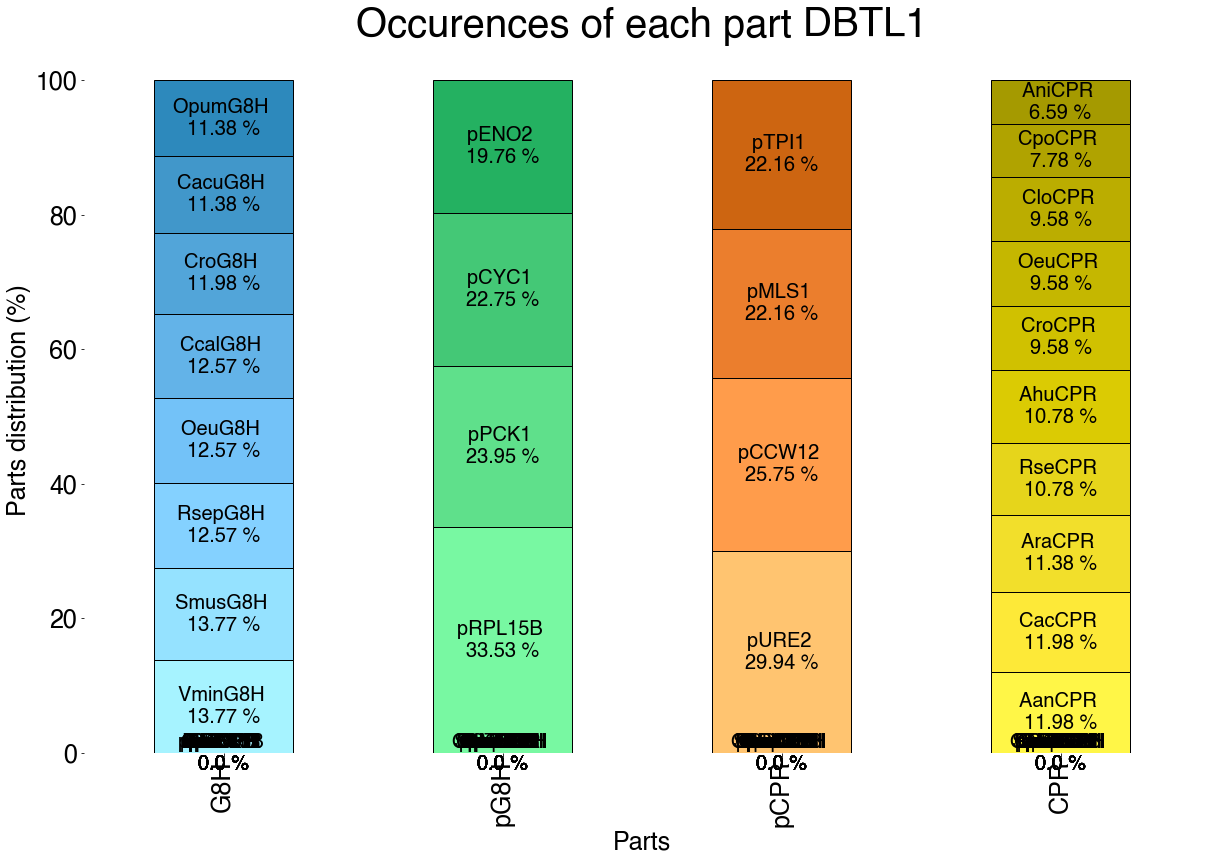

In [106]:
plot_stacked_barplot_with_labels(all_df_for_stacked_plot,all_colors1, 
                    title = 'Occurences of each part DBTL1', 
                     y_label = 'Parts' ,
                         x_label = 'Parts distribution (%)',
                         path = 'G8H_CPR_library/data/10-plots/06_1_TEST_Library_characterization/',
                                 size_heigth = 13
                                )

#### Top20 Strains

In [107]:
first_round_top_producers = pd.read_csv('G8H_CPR_library/data/09-AutoML/input_to_ml/first_round/input_for_ml_1st_iteration_all_analytics.csv')
first_round_top_producers = first_round_top_producers.sort_values(by='Amt_norm', ascending=False)

In [108]:
first_round_top_producers

,Line_name,0,1,2,3,Amt_uM_Strictosidine,Amt_norm
73,yp50_D03,5,2,6,3,85.210149,245.034275
75,yp50_G03,6,2,6,5,54.362482,156.327285
86,yp50_E05,5,1,6,8,50.194227,144.340857
126,yp51_A02,7,2,6,1,46.443319,135.693498
106,yp50_A09,4,2,6,3,46.710102,134.321746
...,...,...,...,...,...,...,...
60,yp50_E01,5,3,5,7,0.000000,0.000000
114,yp50_D11,5,4,8,6,0.000000,0.000000
24,yp49_E05,2,3,7,8,0.000000,0.000000
27,yp49_H05,3,3,7,10,0.000000,0.000000


In [109]:
first_round_top_producers = input_for_ml[['Line_name','G8H', 'pG8H','pCPR', 'CPR', 'Amt_norm']].sort_values(by= 'Amt_norm', ascending = False).reset_index()

In [110]:
# taking the coloumns we are interesterd in: 
top_producers_1st = first_round_top_producers[['G8H', 'pG8H','pCPR', 'CPR','Amt_norm' ]]
# Using DataFrame.agg() to combine two columns of text
top_producers_1st["Names"] = top_producers_1st[['G8H', 'pG8H','pCPR', 'CPR']].agg('-'.join, axis=1)

# taking the top20
first_round_top_producers_TOP20 = top_producers_1st[:20][::-1]
first_round_top_producers_TOP20= first_round_top_producers_TOP20.reset_index()

/var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/ipykernel_7114/1545392891.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_producers_1st["Names"] = top_producers_1st[['G8H', 'pG8H','pCPR', 'CPR']].agg('-'.join, axis=1)


In [111]:
# making range 19-0
index_list  = [str(i) for i in range(19,-1,-1)]

# adding index to names
first_round_top_producers_TOP20['new_index'] = index_list
first_round_top_producers_TOP20['Names_index'] = first_round_top_producers_TOP20[['new_index','Names']].agg('-'.join, axis=1)
names_with_index_top20 = list(first_round_top_producers_TOP20['Names_index'])

Make the final input for the horisontal bar plot

In [112]:
indexes_top20 = list(first_round_top_producers_TOP20.index)
names_top20 = list(first_round_top_producers_TOP20['Names'])
normalized_strict_top20 = list(first_round_top_producers_TOP20['Amt_norm'])

#### Top 20 strains 

In [113]:
from teemi.learn.plotting import horisontal_bar_plot

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


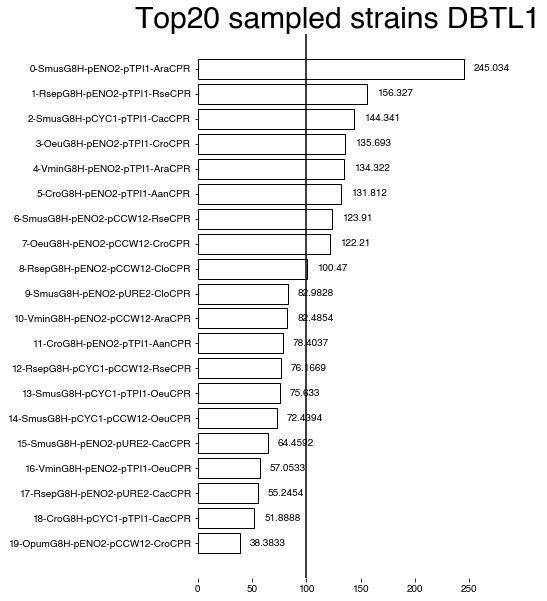

In [114]:
horisontal_bar_plot(names_with_index_top20,normalized_strict_top20, save_pdf= True , 
                    path = 'G8H_CPR_library/data/10-plots/06_1_TEST_Library_characterization/Top_20_strains_from_dbtl1', 
                    title = 'Top20 sampled strains DBTL1', 
                   size_height=5, 
                   size_length=10)

### Statistics on QC - how many strains were fully genotype vs. non-fully genotyped

These are the genotyped strains

In [115]:
first_round_top_producers['Genotyped'] = 'Fully - (Promoters and enzyme homologs)'
first_round_top_producers

,index,Line_name,G8H,pG8H,pCPR,CPR,Amt_norm,Genotyped
0,73,yp50_D03,SmusG8H,pENO2,pTPI1,AraCPR,245.034275,Fully - (Promoters and enzyme homologs)
1,75,yp50_G03,RsepG8H,pENO2,pTPI1,RseCPR,156.327285,Fully - (Promoters and enzyme homologs)
2,86,yp50_E05,SmusG8H,pCYC1,pTPI1,CacCPR,144.340857,Fully - (Promoters and enzyme homologs)
3,126,yp51_A02,OeuG8H,pENO2,pTPI1,CroCPR,135.693498,Fully - (Promoters and enzyme homologs)
4,106,yp50_A09,VminG8H,pENO2,pTPI1,AraCPR,134.321746,Fully - (Promoters and enzyme homologs)
...,...,...,...,...,...,...,...,...
162,60,yp50_E01,SmusG8H,pPCK1,pCCW12,AniCPR,0.000000,Fully - (Promoters and enzyme homologs)
163,114,yp50_D11,SmusG8H,pRPL15B,pURE2,AhuCPR,0.000000,Fully - (Promoters and enzyme homologs)
164,24,yp49_E05,OpumG8H,pPCK1,pMLS1,CacCPR,0.000000,Fully - (Promoters and enzyme homologs)
165,27,yp49_H05,CroG8H,pPCK1,pMLS1,CpoCPR,0.000000,Fully - (Promoters and enzyme homologs)


These are the ones only partly genotyped strains

In [116]:
sorted_df_lcms1['Genotyped'] = 'Partially'

THese were analyzed but did not go through the quality check 

In [117]:
genotyping_and_analytics2 = sorted_df_lcms1[ ~(sorted_df_lcms1['Line_name'].isin(first_round_top_producers['Line_name']))] 
genotyping_and_analytics2 = genotyping_and_analytics2[['Line_name','norm_strict_%']]
genotyping_and_analytics2.columns = ['Line_name', 'Amt_norm']
genotyping_and_analytics2['Genotyped'] = 'Partially - (only enzyme homologs)'
genotyping_and_analytics2

,Line_name,Amt_norm,Genotyped
27,yp50_F09,26.120737,Partially - (only enzyme homologs)
42,yp50_E11,7.314463,Partially - (only enzyme homologs)
51,yp51_E09,4.062490,Partially - (only enzyme homologs)
52,yp49_G04,4.045133,Partially - (only enzyme homologs)
62,yp51_E10,3.073312,Partially - (only enzyme homologs)
...,...,...,...
216,yp49_C05,0.000000,Partially - (only enzyme homologs)
218,yp51_C08,0.000000,Partially - (only enzyme homologs)
226,yp51_B12,0.000000,Partially - (only enzyme homologs)
228,yp51_B08,0.000000,Partially - (only enzyme homologs)


In [118]:
# taking the columns we are interested in: 
genotyped_strains = first_round_top_producers[['Line_name', 'Amt_norm', 'Genotyped']]

This will be used for plotting the genotypes we have

In [119]:
concated_genotypes = pd.concat([genotyping_and_analytics2,genotyped_strains ]).sort_values(by= 'Amt_norm', ascending = False).reset_index()

In [120]:
concated_genotypes

,index,Line_name,Amt_norm,Genotyped
0,0,yp50_D03,245.034275,Fully - (Promoters and enzyme homologs)
1,1,yp50_G03,156.327285,Fully - (Promoters and enzyme homologs)
2,2,yp50_E05,144.340857,Fully - (Promoters and enzyme homologs)
3,3,yp51_A02,135.693498,Fully - (Promoters and enzyme homologs)
4,4,yp50_A09,134.321746,Fully - (Promoters and enzyme homologs)
...,...,...,...,...
233,151,yp49_B09,0.000000,Partially - (only enzyme homologs)
234,152,yp51_E06,0.000000,Partially - (only enzyme homologs)
235,154,yp51_E03,0.000000,Partially - (only enzyme homologs)
236,165,yp50_D10,0.000000,Partially - (only enzyme homologs)


In [121]:
print(f'The number of strains that didnt go through the QC :  {len(genotyping_and_analytics2)} ; ({len(genotyping_and_analytics2)/len(concated_genotypes)*100:.2f}%)')
print(f'The number of strains that DID go through the QC :  {len(genotyped_strains)} ; ({len(genotyped_strains)/len(concated_genotypes)*100:.2f}%)')

The number of strains that didnt go through the QC :  71 ; (29.83%)
The number of strains that DID go through the QC :  167 ; (70.17%)


In [122]:
concated_genotypes.to_csv('G8H_CPR_library/data/07-lcms/processed/lcms_data/genotypes_yp49_51_w_wo_full_genotype.csv')

# 5. Distribution of top strains sampled from notebook 6.

In [123]:
parts_sampled_strains = pd.read_csv('G8H_CPR_library/data/07-lcms/processed/lcms_data/with_genotypes/genotypes_1st_round_w_wo_full_genotype.csv')
parts_sampled_strains = parts_sampled_strains[['Line_name','Amt_norm_x', 'G8H','pG8H', 'pCPR', 'CPR', ]]
parts_sampled_strains

,Line_name,Amt_norm_x,G8H,pG8H,pCPR,CPR
0,yp50_D03,245.034275,SmusG8H,pENO2,pTPI1,AraCPR
1,yp50_G03,156.327285,RsepG8H,pENO2,pTPI1,RseCPR
2,yp50_E05,144.340857,SmusG8H,pCYC1,pTPI1,CacCPR
3,yp51_A02,135.693498,OeuG8H,pENO2,pTPI1,CroCPR
4,yp50_A09,134.321746,VminG8H,pENO2,pTPI1,AraCPR
...,...,...,...,...,...,...
233,yp49_B09,0.000000,NaN,NaN,NaN,NaN
234,yp51_E06,0.000000,NaN,NaN,NaN,NaN
235,yp51_E03,0.000000,NaN,NaN,NaN,NaN
236,yp50_D10,0.000000,NaN,NaN,NaN,NaN


In [124]:
list_of_parts = []
parst_index = []

for index, row in parts_sampled_strains.iterrows():
    list_of_parts.append(row['G8H'])
    list_of_parts.append(row['pG8H'])
    list_of_parts.append(row['pCPR'])
    list_of_parts.append(row['CPR'])
    parst_index.append(index)
    parst_index.append(index)
    parst_index.append(index)
    parst_index.append(index)

distribution = [25]*len(parst_index)
print(len(list_of_parts))
print(len(parst_index))
print(len(distribution))

952
952
952


In [125]:
d = {'Index':parst_index,'Part':list_of_parts, 'Distribution':distribution }
df2 = pd.DataFrame(d)

In [126]:
df2 = df2.replace(np.nan, 'Not_fully_genotyped')

In [127]:
pd.set_option('display.max_columns', None)

In [128]:
cross_tab_prop = pd.crosstab(index=df2['Index'],
                             columns=df2['Part'])
cross_tab_prop

Part,AanCPR,AhuCPR,AniCPR,AraCPR,CacCPR,CacuG8H,CcalG8H,CloCPR,CpoCPR,CroCPR,CroG8H,Not_fully_genotyped,OeuCPR,OeuG8H,OpumG8H,RseCPR,RsepG8H,SmusG8H,VminG8H,pCCW12,pCYC1,pENO2,pMLS1,pPCK1,pRPL15B,pTPI1,pURE2
Index,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,1,0
2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
234,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
235,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [129]:
coloumns = list(cross_tab_prop.columns)

In [130]:
from teemi.learn.plotting import color_range_dict
# importing a range of colors
cpr_color = color_range_dict()['yellow'][::2][::-1]
pcpr_color = color_range_dict()['orange'][::6][::-1]
g8h_color= color_range_dict()['blue'][::3][::-1]
pg8h_color = color_range_dict()['green'][::5][::-1]

Have to make a new colorDict since the names in this data is different

In [131]:
g8h_list_of_index = ["CacuG8H", "OpumG8H","CroG8H","VminG8H","SmusG8H","RsepG8H","OeuG8H","CcalG8H"]
cpr_list_of_index = ["CroCPR", "AanCPR","AraCPR","CloCPR","RseCPR","AhuCPR","AniCPR","CacCPR","OeuCPR","CpoCPR"]
pg8h_list_of_index = ["pCYC1", "pENO2","pPCK1","pRPL15B"]
pcpr_list_of_index = ["pCCW12", "pTPI1","pMLS1","pURE2"]
NaN_list_of_index = ["Not_fully_genotyped"]

all_parts = g8h_list_of_index +cpr_list_of_index+ pg8h_list_of_index+pcpr_list_of_index+ NaN_list_of_index

In [132]:
G8H_color_codes = dict(zip(g8h_list_of_index, g8h_color))
pG8H_color_codes = dict(zip(pg8h_list_of_index, pg8h_color))
pCPR_color_codes = dict(zip(pcpr_list_of_index, pcpr_color))
CPR_color_codes = dict(zip(cpr_list_of_index, cpr_color))

In [133]:
colorDict = dict(G8H_color_codes, **pG8H_color_codes,**pCPR_color_codes, **CPR_color_codes)
colorDict

{'CacuG8H': '#a6f3ff',
 'OpumG8H': '#95e2ff',
 'CroG8H': '#84d1ff',
 'VminG8H': '#73c2f8',
 'SmusG8H': '#63b3e8',
 'RsepG8H': '#52a5d9',
 'OeuG8H': '#4197ca',
 'CcalG8H': '#2d89bc',
 'pCYC1': '#78f8a2',
 'pENO2': '#5fe08b',
 'pPCK1': '#44c876',
 'pRPL15B': '#24b161',
 'pCCW12': '#ffc470',
 'pTPI1': '#ff9c4b',
 'pMLS1': '#eb7e2d',
 'pURE2': '#cd6511',
 'CroCPR': '#fff647',
 'AanCPR': '#fde938',
 'AraCPR': '#f2df2b',
 'CloCPR': '#e6d51b',
 'RseCPR': '#dbcb03',
 'AhuCPR': '#d0c100',
 'AniCPR': '#c5b700',
 'CacCPR': '#bbad00',
 'OeuCPR': '#b0a300',
 'CpoCPR': '#a59a00'}

Making the parts appear in the correct order 

In [134]:
right_order = ['CacuG8H',
 'OpumG8H',
 'CroG8H',
 'VminG8H',
 'SmusG8H',
 'RsepG8H',
 'OeuG8H',
 'CcalG8H',
 'pCYC1',
 'pENO2',
 'pPCK1',
 'pRPL15B',
 'pCCW12',
 'pTPI1',
 'pMLS1',
 'pURE2',    
 'CroCPR',
 'AanCPR',
 'AraCPR',
 'CloCPR',
 'RseCPR',
 'AhuCPR',
 'AniCPR',
 'CacCPR',
 'OeuCPR',
 'CpoCPR', 
 'Not_fully_genotyped']

In [135]:
fixed_columns = []
for name in right_order: 
    if name in coloumns: 
        fixed_columns.append(name)
cross_tab_prop = cross_tab_prop[fixed_columns]

Add a white color to the not_fully_genotype colorDict

In [136]:
colorDict['Not_fully_genotyped'] = '#FFFFFF'

In [137]:
from teemi.learn.plotting import carpet_barplot

In [138]:
import matplotlib
# restore matplotlib aestetic
matplotlib.rc_file_defaults()

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


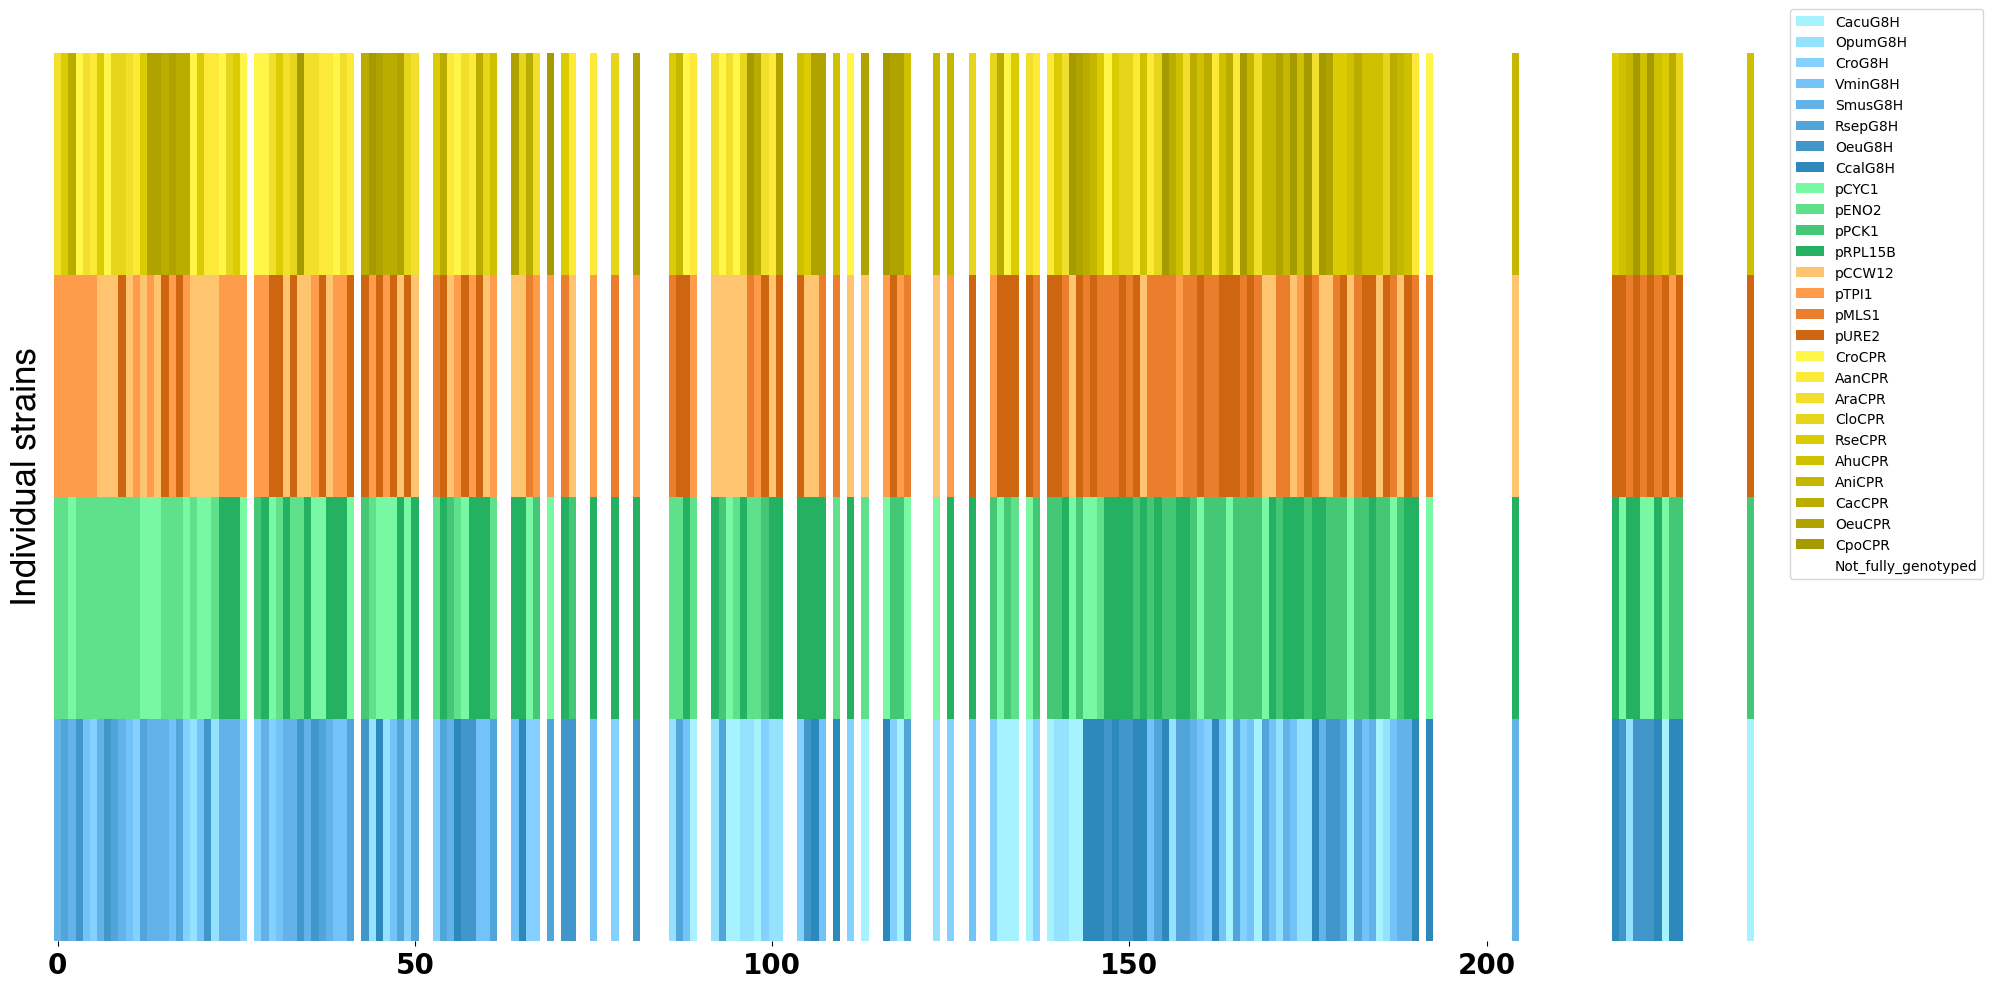

In [139]:
name = 'Carpet_plot_All_genotypes_from_the_first_library_WHITE'
carpet_barplot(cross_tab_prop, colorDict, save_pdf= True ,
               path ='G8H_CPR_library/data/10-plots/08_2_DESIGN_Targeted_library/'+name, 
               xlabel ='' , 
               ylabel = 'Individual strains' )